In [262]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.ticker import ScalarFormatter, FuncFormatter
from scipy.stats import fisher_exact
import psycopg2
from psycopg2.extras import execute_values
from sklearn.metrics import r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

sns.set(style="white")

# --- Global variables ---
RANDOM_STATE = 42
SIGNIFICANCE_LEVEL = 0.05

In [ ]:
# Connect to data warehouse aiaiven possgress to get data
conn = psycopg2.connect(
    ""
)
cursor = conn.cursor() 

# sql = '''SELECT * FROM dim_demographics;'''
sql_query = """
SELECT 
    fam.ad_id,
    fam.Impressions as "Impressions",
    fam.Clicks as "Clicks",
    fam.Total_Conversion as "Total_Conversion",
    fam.Approved_Conversion as "Approved_Conversion",
    fam.xyz_campaign_id as "xyz_campaign_id",
    dc.fb_campaign_id,
    dd.age,
    dd.gender,
    dd.Spent as "Spent",
    di.interest
FROM fact_ads_metrics fam
LEFT JOIN dim_campaign dc ON fam.fb_campaign_id = dc.fb_campaign_id
LEFT JOIN dim_demographics dd ON fam.demographic_id = dd.demographic_id
LEFT JOIN dim_interest di ON fam.interest_id = di.interest_id;
"""
sales = pd.read_sql(sql_query, conn)
conn.commit() 
sales


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_23628\1650418603.py:26: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sales = pd.read_sql(sql_query, conn)


,ad_id,Impressions,Clicks,Total_Conversion,Approved_Conversion,xyz_campaign_id,fb_campaign_id,age,gender,Spent,interest
0,708746,7350,1,2,1,916,103916,30-34,M,1.430000,15
1,708749,17861,2,2,0,916,103917,30-34,M,1.820000,16
2,708771,693,0,1,0,916,103920,30-34,M,0.000000,20
3,708815,4259,1,1,0,916,103928,30-34,M,1.250000,28
4,708818,4133,1,1,1,916,103928,30-34,M,1.290000,28
...,...,...,...,...,...,...,...,...,...,...,...
1138,1314410,1129773,252,13,2,1178,179977,45-49,F,358.189997,109
1139,1314411,637549,120,3,0,1178,179978,45-49,F,173.880003,110
1140,1314412,151531,28,2,0,1178,179979,45-49,F,40.289999,111
1141,1314414,790253,135,8,2,1178,179981,45-49,F,198.710001,113


In [264]:
file_path = '../data/raw/KAG_conversion_data.csv'
sales = pd.read_csv(file_path)
print(f"Rows: {sales.shape[0]:,}")
print(f"Cols: {sales.shape[1]:,}")
print(sales.dtypes)
sales.head(3)

Rows: 1,143
Cols: 11
ad_id                    int64
xyz_campaign_id          int64
fb_campaign_id           int64
age                     object
gender                  object
interest                 int64
Impressions              int64
Clicks                   int64
Spent                  float64
Total_Conversion         int64
Approved_Conversion      int64
dtype: object


,ad_id,xyz_campaign_id,fb_campaign_id,age,gender,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion
0,708746,916,103916,30-34,M,15,7350,1,1.43,2,1
1,708749,916,103917,30-34,M,16,17861,2,1.82,2,0
2,708771,916,103920,30-34,M,20,693,0,0.00,1,0


The columns are described as follows: 

| Column              | Description                                                                                              |
|:--------------------|:---------------------------------------------------------------------------------------------------------|
| `ad_id`               | A unique ID for each ad.                                                                                 |
| `xyz_campaign_id`     | An ID associated with each ad campaign of XYZ company.                                                   |
| `fb_campaign_id`      | An ID associated with how Facebook tracks each campaign.                                                 |
| `age`                 | Age of the person to whom the ad is shown.                                                               |
| `gender`              | Gender of the person to whom the ad is shown.                                                            |
| `interest`            | A code specifying the category to which the person’s interest belongs (as mentioned in the person’s Facebook public profile). |
| `Impressions`         | The number of times the ad was shown.                                                                    |
| `Clicks`              | Number of clicks on that ad.                                                                             |
| `Spent`               | Amount paid by company XYZ to Facebook to show that ad.                                                  |
| `Total conversion`    | Total number of people who enquired about the product after seeing the ad.                               |
| `Approved conversion` | Total number of people who bought the product after seeing the ad.                                       |


<h2 style="font-family: 'Palatino Linotype', 'Book Antiqua', Palatino, serif; font-size: 36px; color: #2C3E50; font-weight: bold; text-align: left; margin-top: 20px; background-color: rgba(225, 190, 231, 0.6); padding: 20px; border-radius: 10px;">
    Descriptive Analysis
</h2>

In this section we are going to take a look at some summary statistics for the numerical variables. Additionally we are going to investigate the cardinalities of the categorical columnns.

In [265]:
# --- Basic statistics ---
pd.DataFrame(
    {
        'Missing Count (#)': sales.isnull().sum(),
        'Missing Rate (%)': 100 * sales.isnull().mean(),
        # 'Unique Count (#)': sales.nunique(),
        # 'Unique Rate (%)': round(100 * sales.nunique() / sales.shape[0], 2),
        'Duplicates Count (#)': [sales[c].duplicated().sum() for c in sales.columns],
        'Duplicates Rate (%)': [round(100 * sales[c].duplicated().sum() / sales.shape[0], 2) for c in sales.columns],
    }
)

,Missing Count (#),Missing Rate (%),Duplicates Count (#),Duplicates Rate (%)
ad_id,0,0.0,0,0.00
xyz_campaign_id,0,0.0,1140,99.74
fb_campaign_id,0,0.0,452,39.55
age,0,0.0,1139,99.65
gender,0,0.0,1141,99.83
interest,0,0.0,1103,96.50
Impressions,0,0.0,13,1.14
Clicks,0,0.0,960,83.99
Spent,0,0.0,274,23.97
Total_Conversion,0,0.0,1111,97.20


- There are no missing values in the dataset 😊. 
- The dataset contains data of __1143 adds__.
- There are only __3 xyz campaigns__ in the dataset.
- There are __691 Facebook campaigns__ in the dataset.
- The customers are segmented into 4 age buckets.

<h3 style="font-family: 'Palatino Linotype', 'Book Antiqua', Palatino, serif; font-size: 28px; color: #2C3E50; font-weight: normal; text-align: left; margin-top: 15px; background: linear-gradient(to right, rgba(240, 240, 240, 0.8), rgba(220, 220, 220, 0.8)); padding: 15px; border-left: 5px solid #CB99C9; border-radius: 5px;">
    Numerical Variables
</h3>

In [266]:
sales_numericals = sales.select_dtypes(include=['int64', 'float64'])

sales_numericals.describe().apply(lambda s: s.apply(lambda x: f"{x:,.2f}"))

,ad_id,xyz_campaign_id,fb_campaign_id,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion
count,"1,143.00","1,143.00","1,143.00","1,143.00","1,143.00","1,143.00","1,143.00","1,143.00","1,143.00"
mean,"987,261.13","1,067.38","133,783.99",32.77,"186,732.13",33.39,51.36,2.86,0.94
std,"193,992.81",121.63,"20,500.31",26.95,"312,762.18",56.89,86.91,4.48,1.74
min,"708,746.00",916.00,"103,916.00",2.00,87.00,0.00,0.00,0.00,0.00
25%,"777,632.50",936.00,"115,716.00",16.00,"6,503.50",1.00,1.48,1.00,0.00
50%,"1,121,185.00","1,178.00","144,549.00",25.00,"51,509.00",8.00,12.37,1.00,1.00
75%,"1,121,804.50","1,178.00","144,657.50",31.00,"221,769.00",37.50,60.02,3.00,1.00
max,"1,314,415.00","1,178.00","179,982.00",114.00,"3,052,003.00",421.00,639.95,60.00,21.00


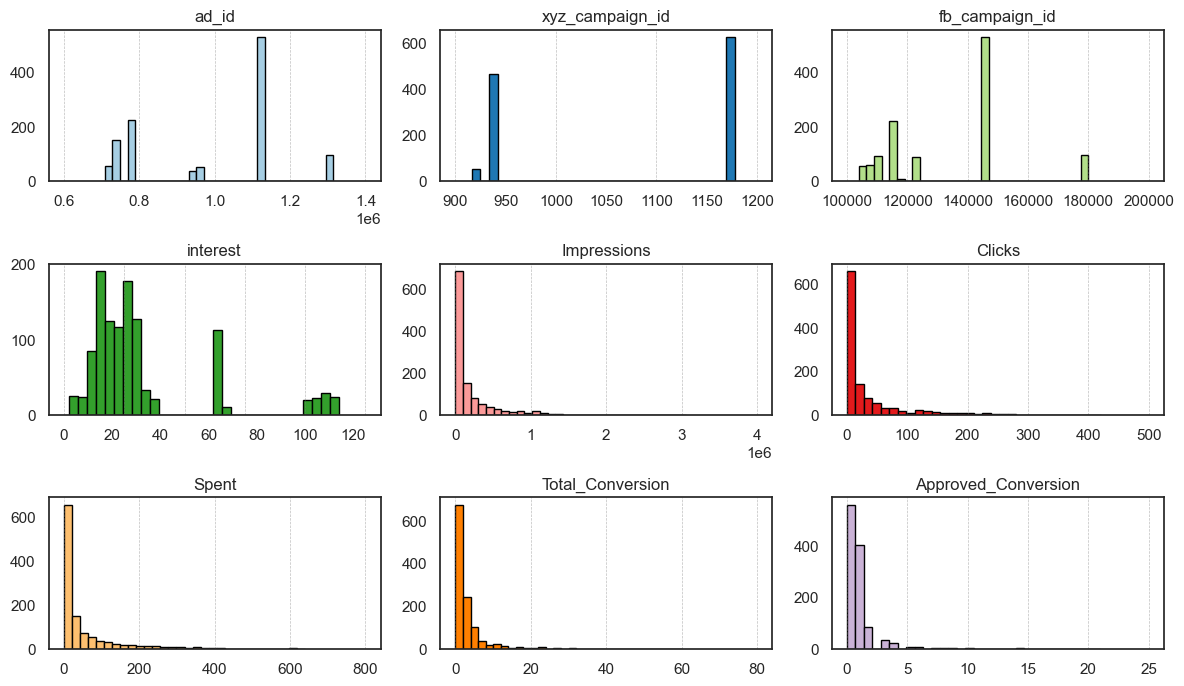

In [267]:
fig, axes = plt.subplots(3, 3, figsize=(12, 7))
axes = axes.flatten()

colors = sns.color_palette("Paired", 9)

for i, col in enumerate(sales_numericals):
    ax = axes[i]
    ax.hist(sales[col].dropna(), bins=30, color=colors[i % len(colors)], edgecolor='black')
    ax.set_title(col)
    
    # Disable scientific notation on y-axis.
    ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
    ax.ticklabel_format(style='plain', axis='y')    
    
    for tick in ax.get_xticks():
        if tick < 0: continue
        ax.axvline(x=tick, color='grey', alpha=0.5, linestyle='--', linewidth=0.5)       

for j in range(i + 1, len(axes)): axes[j].set_visible(False)

plt.tight_layout(pad=1.0)
plt.show()

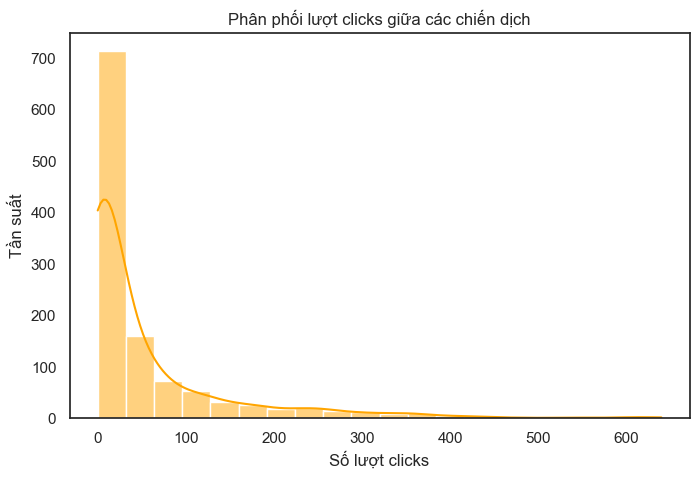

In [268]:

# ax.hist(sales['Spent'].dropna(), bins=30, color=colors[i % len(colors)], edgecolor='black')
# ax.set_title(col)

# plt.tight_layout(pad=1.0)
# plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(sales['Spent'], kde=True, bins=20, color='orange')
plt.title('Phân phối lượt clicks giữa các chiến dịch')
plt.xlabel('Số lượt clicks')
plt.ylabel('Tần suất')
plt.show()

<h3 style="font-family: 'Palatino Linotype', 'Book Antiqua', Palatino, serif; font-size: 28px; color: #2C3E50; font-weight: normal; text-align: left; margin-top: 15px; background: linear-gradient(to right, rgba(240, 240, 240, 0.8), rgba(220, 220, 220, 0.8)); padding: 15px; border-left: 5px solid #CB99C9; border-radius: 5px;">
    Categorical Variables
</h3>

In [269]:
sales_categoricals = sales.select_dtypes(exclude=['int64', 'float64'])

sales_categoricals.value_counts()

age    gender
30-34  M         229
       F         197
35-39  M         139
45-49  F         138
       M         121
35-39  F         109
40-44  F         107
       M         103
Name: count, dtype: int64

In [270]:
sales

,ad_id,xyz_campaign_id,fb_campaign_id,age,gender,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion
0,708746,916,103916,30-34,M,15,7350,1,1.430000,2,1
1,708749,916,103917,30-34,M,16,17861,2,1.820000,2,0
2,708771,916,103920,30-34,M,20,693,0,0.000000,1,0
3,708815,916,103928,30-34,M,28,4259,1,1.250000,1,0
4,708818,916,103928,30-34,M,28,4133,1,1.290000,1,1
...,...,...,...,...,...,...,...,...,...,...,...
1138,1314410,1178,179977,45-49,F,109,1129773,252,358.189997,13,2
1139,1314411,1178,179978,45-49,F,110,637549,120,173.880003,3,0
1140,1314412,1178,179979,45-49,F,111,151531,28,40.289999,2,0
1141,1314414,1178,179981,45-49,F,113,790253,135,198.710001,8,2


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_23628\616445613.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sns.countplot(data=sales, x=col,
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_23628\616445613.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sns.countplot(data=sales, x=col,


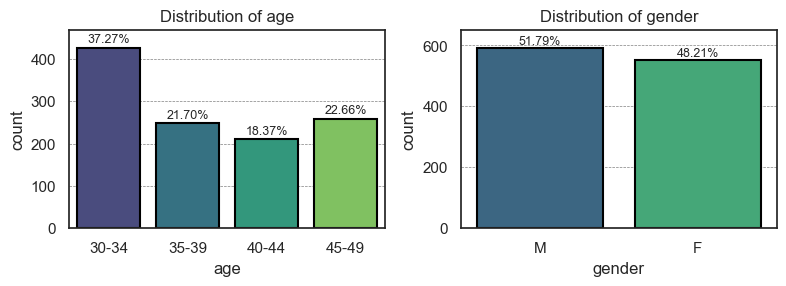

In [271]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes = axes.flatten()

for i, col in enumerate(sales_categoricals):
    ax = axes[i]
    
    plot = sns.countplot(data=sales, x=col, 
                         palette='viridis', edgecolor='black', linewidth=1.5, 
                         ax=ax)
    ax.set_title(f'Distribution of {col}')
    ax.grid(axis='y', color='grey', linestyle='--', linewidth=0.5)    
    
    # Add percentage at the top of each bar.
    total = len(sales[col])
    max_height = 0
    for p in plot.patches:
        height = p.get_height()
        max_height = max(max_height, height)
        percentage = 100 * height / total
        ax.text(p.get_x() + p.get_width() / 2., height + 12, 
                f'{percentage:.2f}%', ha='center', fontsize=9)

    ax.set_ylim(0, max_height * 1.10)
    

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout(pad=1.0)
plt.show()

<h2 style="font-family: 'Palatino Linotype', 'Book Antiqua', Palatino, serif; font-size: 36px; color: #2C3E50; font-weight: bold; text-align: left; margin-top: 20px; background-color: rgba(225, 190, 231, 0.6); padding: 20px; border-radius: 10px;">
    Exploratory Data Analysis (EDA)
</h2>

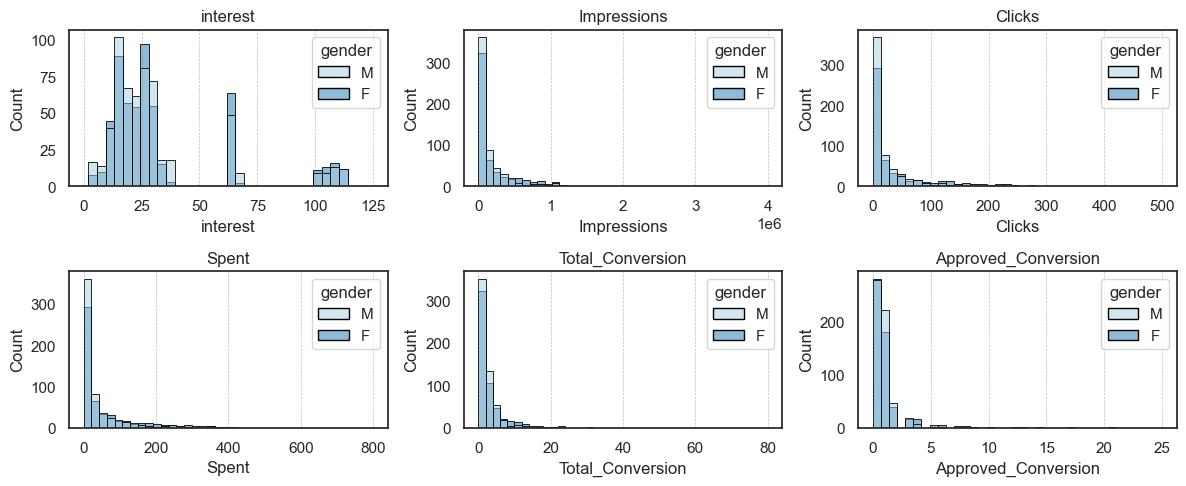

In [272]:
fig, axes = plt.subplots(2, 3, figsize=(12, 5))
axes = axes.flatten()

colors = sns.color_palette("Paired", 9)

for i, col in enumerate([x for x in sales_numericals if x not in ['ad_id', 'xyz_campaign_id', 'fb_campaign_id']]):
    ax = axes[i]
    sns.histplot(data=sales, x=col, hue='gender', bins=30, palette="Paired", ax=ax, edgecolor='black')
    ax.set_title(col)
    
    # Disable scientific notation on y-axis.
    ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
    ax.ticklabel_format(style='plain', axis='y')    
    
    for tick in ax.get_xticks():
        if tick < 0: continue
        ax.axvline(x=tick, color='grey', alpha=0.5, linestyle='--', linewidth=0.5)       

for j in range(i + 1, len(axes)): axes[j].set_visible(False)

plt.tight_layout(pad=1.0)
plt.show()

Now we will compare the proportion of males versus females within each campaign (`xyz_campaign_id`). To test whether there is a significant difference in the gender distribution (male vs. female) for each campaign we are going to use [Fisher's Exact Test](https://en.wikipedia.org/wiki/Fisher%27s_exact_test). This test is performed on a $2 \times 2$ contingency table. The null hypothesis ($H_0$) and alternative hypothesis ($H_1$) are as follows: 

$$
\begin{align}
    H_0: &\text{ There is no association between gender (male or female) and the campaign.} \\
         &\text{ In other words, the distribution of males and females within the campaign is due to random chance.} \\
         &\text{ The proportion of males and females is the same across this campaign.} \\
    H_1: &\text{ There is a significant association between gender and the campaigny. } \\    
         &\text{ This means that the distribution of males and females within the campaign differs from what would be expected by chance.} \\    
         &\text{ The proportion of males and females differs in this campaign.} \\
\end{align}         
$$

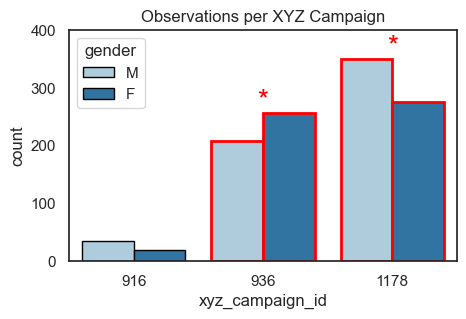

In [273]:
plt.figure(figsize=(5, 3))

ax = sns.countplot(data=sales, x='xyz_campaign_id', hue='gender', palette="Paired", edgecolor='black')
plt.title('Observations per XYZ Campaign')
plt.ylim((0, 400))

# ------------------- #
# Statistical testing #
# ------------------- #

significant_campaign_idx = []

# --- Perform Fisher's Exact Test for each interest category ---
for i, campaign in enumerate(sorted(sales['xyz_campaign_id'].unique())):
    contingency_table = pd.crosstab(sales['gender'], sales['xyz_campaign_id'] == campaign)    
    _, p_value = fisher_exact(contingency_table)

    if p_value < SIGNIFICANCE_LEVEL:
        significant_campaign_idx.append(i)

# Visualize the interest categories for which the difference between M and F is significant.
for campaign in significant_campaign_idx:
    patches = [patch for patch in ax.patches if round(patch.get_x() + patch.get_width() / 2) == campaign]
    
    if patches:
        for patch in patches:
            patch.set_edgecolor('red')
            patch.set_linewidth(2)

        # Show an asterix for better visualization.
        if len(patches) == 2:
            midpoint = (patches[0].get_x() + patches[1].get_x() + patches[0].get_width()) / 2
            plt.text(midpoint, max(p.get_height() for p in patches)-1, '*', 
                     ha='center', va='bottom', fontsize=20, color='red')

> We see that the proportion of males and females significantly differs for two campaigns (`xyz_campaign_id`), namely $936$ and $1178$.

Now we will do the same for the `Interest` category. Thus, we will test the significance of the proportion of males versus females within each `Interest` category.

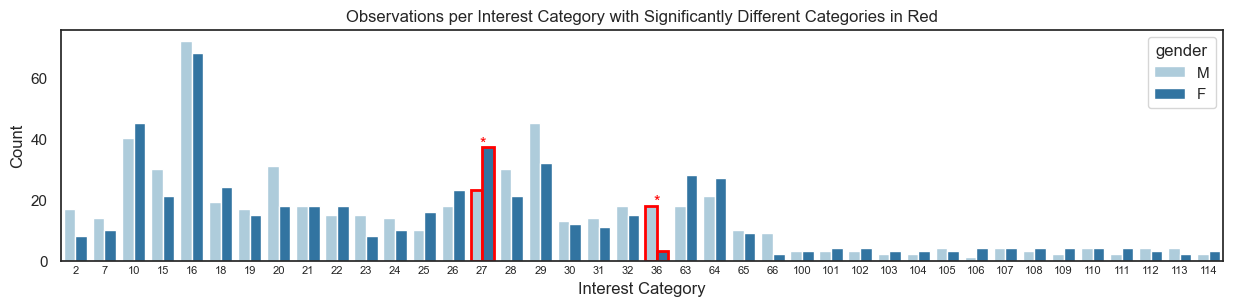

In [274]:
# -------- #
# Plotting #
# -------- #

plt.figure(figsize=(15, 3))

ax = sns.countplot(data=sales, x='interest', hue='gender', palette="Paired")
plt.title('Observations per Interest Category with Significantly Different Categories in Red')
plt.xlabel('Interest Category')
plt.ylabel('Count')
plt.xticks(fontsize=8)
plt.tick_params(axis='x', which='both', direction='in', length=6)


# ------------------- #
# Statistical testing #
# ------------------- #

significant_categories_idx = []

# --- Perform Fisher's Exact Test for each interest category ---
for i, category in enumerate(sorted(sales['interest'].unique())):
    contingency_table = pd.crosstab(sales['gender'], sales['interest'] == category)
    
    _, p_value = fisher_exact(contingency_table)

    if p_value < SIGNIFICANCE_LEVEL:
        significant_categories_idx.append(i)

# Visualize the interest categories for which the difference between M and F is significant.
for category in significant_categories_idx:
    patches_for_category = [patch for patch in ax.patches if round(patch.get_x() + patch.get_width() / 2) == category]
    
    if patches_for_category:
        for patch in patches_for_category:
            patch.set_edgecolor('red')
            patch.set_linewidth(2)

        # Show an asterix for better visualization.
        if len(patches_for_category) == 2:
            midpoint = (patches_for_category[0].get_x() + patches_for_category[1].get_x() + patches_for_category[0].get_width()) / 2
            plt.text(midpoint, max(p.get_height() for p in patches_for_category)-1, '*', 
                     ha='center', va='bottom', fontsize=12, color='red')

plt.show()

We see that for two `Interest` categories we were able to reject the null hypothesis $H_0$.
> Therefore we can conclude that there is a significant association between `Gender` and the `Interest` categories $27$ and $36$ respectively.

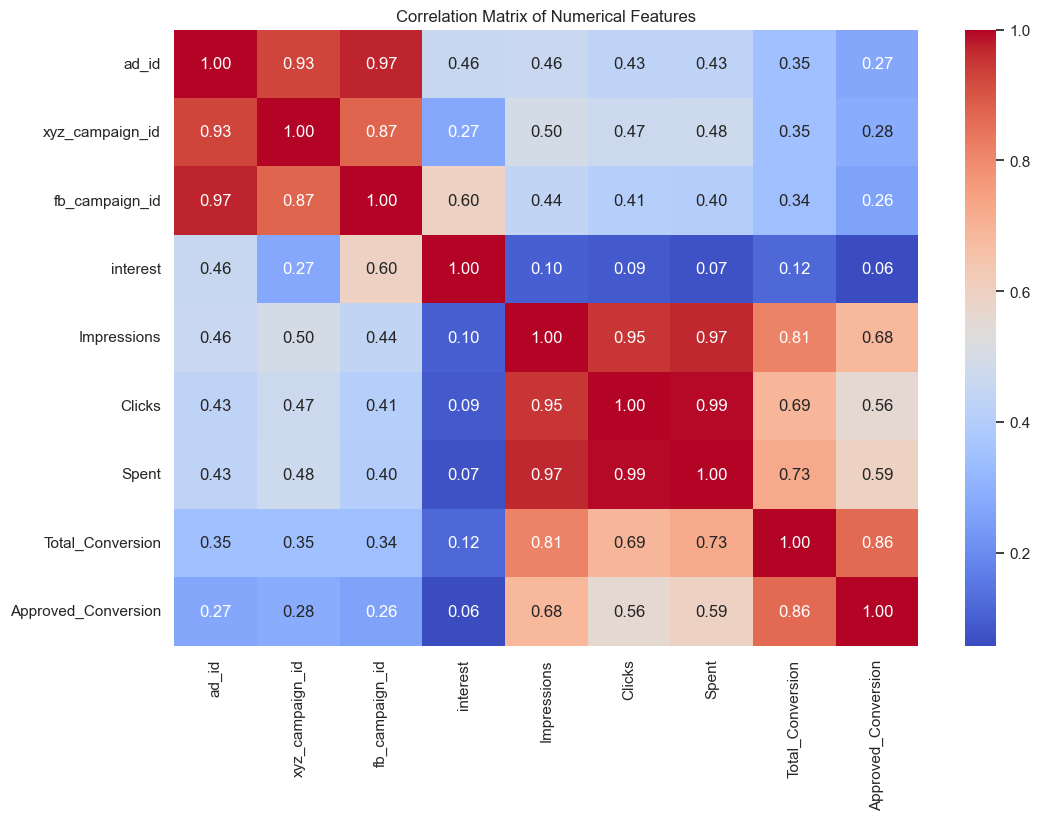

In [275]:
numeric_columns = sales.select_dtypes(include=['number'])

# Tính toán ma trận tương quan
correlation_matrix = numeric_columns.corr()

# Vẽ heatmap cho ma trận tương quan
plt.figure(figsize=(12, 8))  # Điều chỉnh kích thước biểu đồ
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)

plt.title("Correlation Matrix of Numerical Features")
plt.show()

<h2 style="font-family: 'Palatino Linotype', 'Book Antiqua', Palatino, serif; font-size: 36px; color: #2C3E50; font-weight: bold; text-align: left; margin-top: 20px; background-color: rgba(225, 190, 231, 0.6); padding: 20px; border-radius: 10px;">
    Conversion Rate Analysis
</h2>

Let's first clarify some definitions: 

$$
\begin{align}
    \textbf{Click-Through Rate}        &= CTR &&= \frac{\text{Clicks}}{\text{Impressions}} \times 100\%         \quad &\text{Percentage of impressions that resulted in clicks} \\
    \textbf{Total Conversion Rate}     &= CR  &&= \frac{\text{Total_Conversion}}{\text{Clicks}} \times 100\%    \quad &\text{Percentage of clicks that resulted in any conversion} \\
    \textbf{Approved Conversion Rate}  &=     &&= \frac{\text{Approved_Conversion}}{\text{Clicks}} \times 100\% \quad &\text{Percentage of clicks that resulted in approved conversions}\\    
    \textbf{Cost Per Click}            &= CPC &&= \frac{\text{Spent}}{\text{Clicks}}                            \quad &\text{Cost efficiency per click}\\    
    \textbf{Cost Per Conversion}       &=     &&= \frac{\text{Spent}}{\text{Total_Conversion}}                  \quad &\text{Cost efficiency per conversion}
\end{align}
$$

In [276]:
sales['Click_Through_Rate']       = (sales['Clicks'] / sales['Impressions']) * 100
sales['Total_Conversion_Rate']    = (sales['Total_Conversion'] / sales['Clicks']) * 100
sales['Approved_Conversion_Rate'] = (sales['Approved_Conversion'] / sales['Clicks']) * 100
sales['Cost_Per_Click']           = sales['Spent'] / sales['Clicks']                 
sales['Cost_Per_Conversion']      = sales['Spent'] / sales['Total_Conversion'] 

conversion_columns = [
    'Click_Through_Rate', 'Total_Conversion_Rate', 'Approved_Conversion_Rate',
    'Cost_Per_Click', 'Cost_Per_Conversion'
]

sales.head(5)

,ad_id,xyz_campaign_id,fb_campaign_id,age,gender,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion,Click_Through_Rate,Total_Conversion_Rate,Approved_Conversion_Rate,Cost_Per_Click,Cost_Per_Conversion
0,708746,916,103916,30-34,M,15,7350,1,1.43,2,1,0.013605,200.0,100.0,1.43,0.715
1,708749,916,103917,30-34,M,16,17861,2,1.82,2,0,0.011198,100.0,0.0,0.91,0.910
2,708771,916,103920,30-34,M,20,693,0,0.00,1,0,0.000000,inf,NaN,NaN,0.000
3,708815,916,103928,30-34,M,28,4259,1,1.25,1,0,0.023480,100.0,0.0,1.25,1.250
4,708818,916,103928,30-34,M,28,4133,1,1.29,1,1,0.024195,100.0,100.0,1.29,1.290


Note that above `1/0=inf` and `0/0=NaN`.

Before we start analysing our data we should be aware of the following: 

- _High CTR_: Indicates that the ad is successful in getting people to click on it.
- _Total Conversion Rate_: Shows the overall effectiveness of turning clicks into any form of conversion.
- _Approved Conversion Rate_: Specifically focuses on conversions that were approved, which might be more critical depending on the campaign goals.
- _CPC and Cost Per Conversion_: Lower values are generally better, indicating cost efficiency in acquiring clicks and conversions.

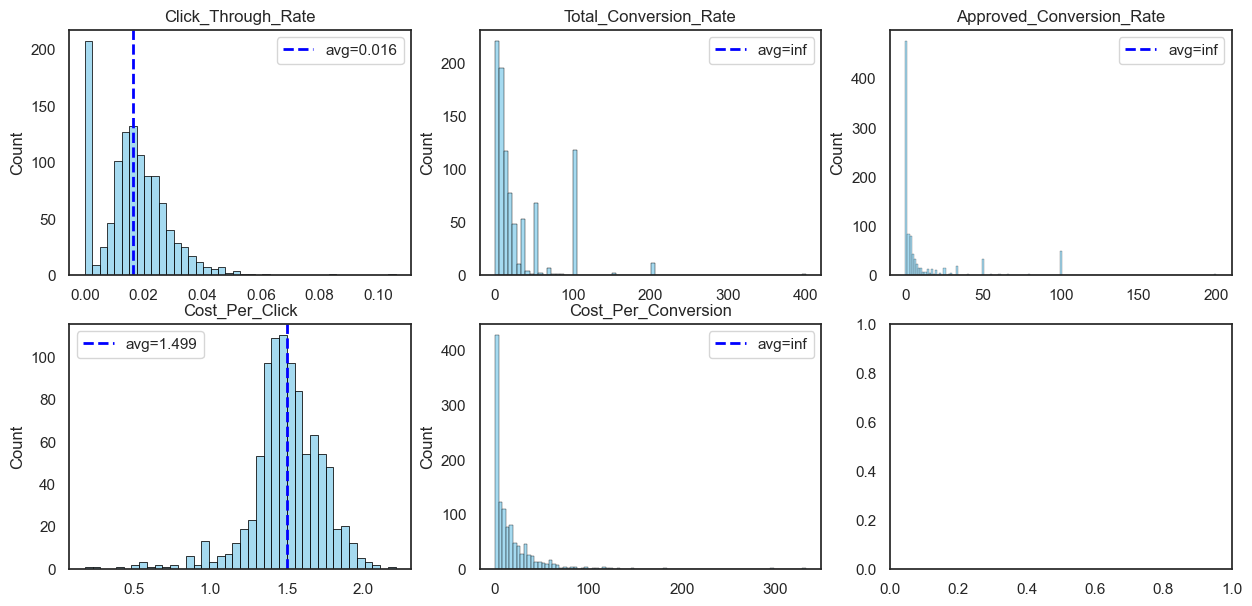

In [277]:
fig, axes = plt.subplots(2, 3, figsize=(15, 7))
axes = axes.flatten()

for i, col in enumerate(conversion_columns):
    sns.histplot(sales, x=col, 
                 color='skyblue', edgecolor='black', ax=axes[i]);
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel(None)
    
    mu = sales[col].mean()
    axes[i].axvline(mu, color='blue', linestyle='dashed', 
                    linewidth=2, label=f'avg={mu:0.3f}')
    axes[i].legend()
    
plt.show()

__Click Through Rate__ (CTR)
- Let's keep in mind that the higher the CTR the better, because then the rate of impressions that resulted in clicks is high.
- The average CTR is are 0.016%. This means that, __on average, 1 click is generated for every 6,250 impressions__. (because 0.016 out of 100 impressions result in a click, and thus, $1/0.00016 \approx 6250$ is how many impressions are needed for 1 click)
- More than 200 ads have a CTR of 0% which indicates that no click at all has been made.

__Total Conversion Rate__ (TCR)
- The distribution is largely left skewed.
- The average TCR is inf. This indicates that, __on average no click resulted in any enquiry (conversion)__.
- There are some adds with have a TCR above 100, which means that the `Total number of people who enquired about the product after seeing the ad` is higher than the `number of people who clicked on that ad`. That can be because a single person who clicked can enquiry more than 1 person. 
- It looks like the maximal TCR is around 400. This indicates that __at least for one ad 4 times more people enquiried the ad compared to clicking on it__.

__Approved Conversion Rate__ (ACR)
- The distribution is even more extremely left skewed than the one of the TCR.
- __Most of the time, no person bought the ad after seeing it__. 

__Cost Per Click__
- The distribution has Gaussian shape.
- On average the cost per click is 1.5.
- The cost per click doesn't fluctuate strongly around the mean.
- The maximal cost per click lies below 2.5. 

__Cost Per Conversion__
- The distribution is highly left skewed.
- At least one ad costs more than 300 for a conversion.

__Summary__

The most interesting findings are: 

> - It takes on average 6,250 impressions to generate a click on an ad.
> 
> - On average no click resulted in any conversion.
> 
> - On average a click costs 1.5. It never costs above 2.5.
> 
> - At least one ad costs more than 300 for a conversion.

<h2 style="font-family: 'Palatino Linotype', 'Book Antiqua', Palatino, serif; font-size: 36px; color: #2C3E50; font-weight: bold; text-align: left; margin-top: 20px; background-color: rgba(225, 190, 231, 0.6); padding: 20px; border-radius: 10px;">
    Segment Analysis
</h2>

In this section we are going to perform segment analysis on the following columns: 

- `Age`: To analyze how different age groups respond to ads in terms of impressions, clicks, and conversions.
- `Gender`: To compare the performance of ads between different genders.
- `Interest`: To evaluate which interest categories have higher conversion rates.

In [278]:
segement_cols_to_analyse = ['Spent', 'Click_Through_Rate', 'Total_Conversion_Rate', 'Approved_Conversion_Rate', 'Cost_Per_Click', 'Cost_Per_Conversion']

<h3 style="font-family: 'Palatino Linotype', 'Book Antiqua', Palatino, serif; font-size: 28px; color: #2C3E50; font-weight: normal; text-align: left; margin-top: 15px; background: linear-gradient(to right, rgba(240, 240, 240, 0.8), rgba(220, 220, 220, 0.8)); padding: 15px; border-left: 5px solid #CB99C9; border-radius: 5px;">
    By Age
</h3>

In [279]:
age_group_analysis = sales.groupby('age').agg({
    'Impressions': 'sum',
    'Clicks': 'sum',
    'Total_Conversion': 'sum',
    'Approved_Conversion': 'sum',
    'Spent': 'sum'
}).reset_index()

age_group_analysis['Click_Through_Rate']       = (age_group_analysis['Clicks']              / age_group_analysis['Impressions']) * 100
age_group_analysis['Total_Conversion_Rate']    = (age_group_analysis['Total_Conversion']    / age_group_analysis['Clicks'])      * 100
age_group_analysis['Approved_Conversion_Rate'] = (age_group_analysis['Approved_Conversion'] / age_group_analysis['Clicks'])      * 100
age_group_analysis['Cost_Per_Click']           = age_group_analysis['Spent']                / age_group_analysis['Clicks']
age_group_analysis['Cost_Per_Conversion']      = age_group_analysis['Spent']                / age_group_analysis['Total_Conversion']

print("Analysis by Age:")
age_group_analysis

Analysis by Age:


,age,Impressions,Clicks,Total_Conversion,Approved_Conversion,Spent,Click_Through_Rate,Total_Conversion_Rate,Approved_Conversion_Rate,Cost_Per_Click,Cost_Per_Conversion
0,30-34,67993019,9483,1431,494,15252.399986,0.013947,15.090161,5.209322,1.608394,10.658560
1,35-39,42104644,7094,626,207,11112.429994,0.016848,8.824359,2.917959,1.566455,17.751486
2,40-44,39604307,7736,523,170,11589.729981,0.019533,6.760600,2.197518,1.498155,22.160096
3,45-49,63732858,13852,684,208,20750.669997,0.021734,4.937915,1.501588,1.498027,30.337237


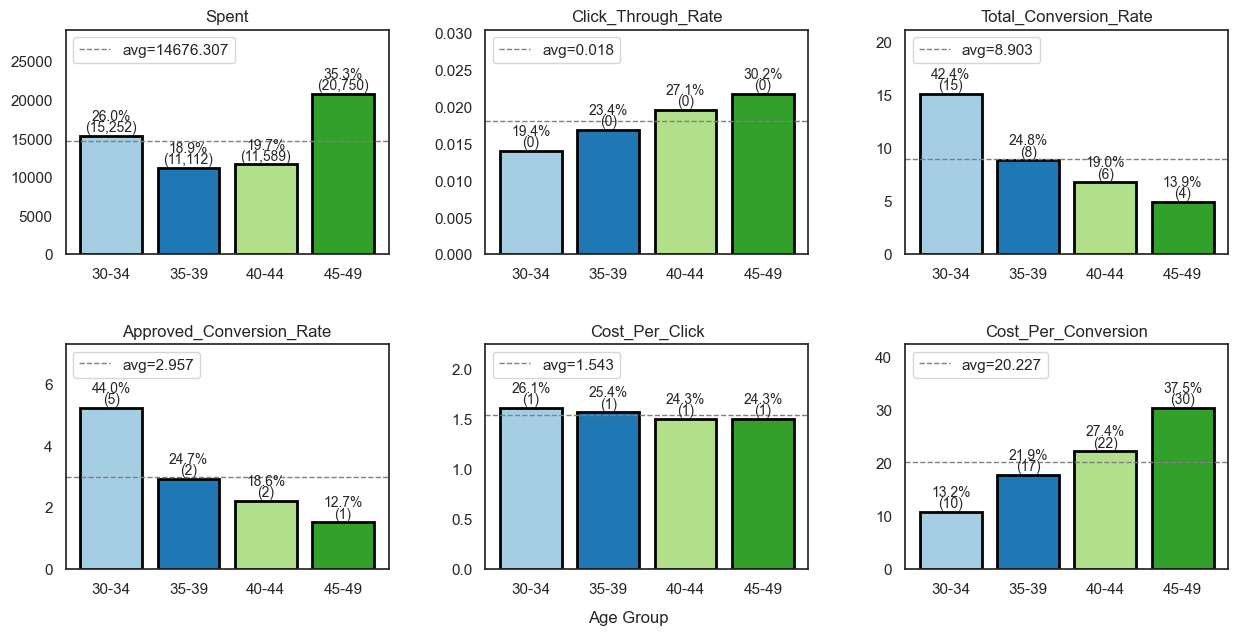

In [280]:
fig, axes = plt.subplots(2, 3, figsize=(15, 7))
axes = axes.flatten()
colors = plt.cm.Paired(range(len(age_group_analysis)))

for i, col in enumerate(segement_cols_to_analyse):
    
    bars = axes[i].bar(age_group_analysis['age'], age_group_analysis[col], 
                color=colors, edgecolor='black', linewidth=2.0)
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel(None)
    axes[i].set_ylim(0, age_group_analysis[col].max() * 1.4)        
    
    mu = age_group_analysis[col].mean()
    axes[i].axhline(mu, color='grey', linestyle='dashed', 
                    linewidth=1, label=f'avg={mu:0.3f}')
    axes[i].legend(loc='upper left')

    # Show counts and percentages.
    for p in bars:
        height = p.get_height()
        percentage = (height / age_group_analysis[col].sum()) * 100
        
        axes[i].text(p.get_x() + p.get_width() / 2., height + 0.08 * max(age_group_analysis[col]), 
                     f'{percentage:.1f}%', ha='center', va='bottom', fontsize=10)
        axes[i].text(p.get_x() + p.get_width() / 2., height + 0.01 * max(age_group_analysis[col]), 
                     f'({int(height):,})', ha='center', va='bottom', fontsize=10)

fig.text(0.5, 0.04, 'Age Group', ha='center', va='center', fontsize=12)
fig.subplots_adjust(hspace=0.4, wspace=0.3)

plt.show()

========== Statistics per age ==========


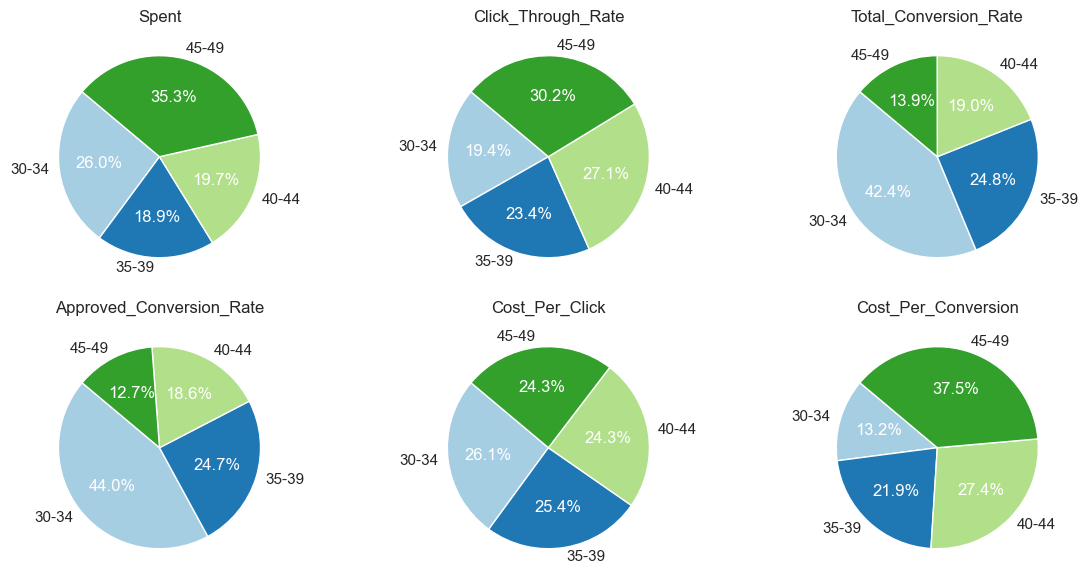

In [281]:
col_to_analyse = 'age'

print(f"{40*'='}")
print(f"{' Statistics per ' + col_to_analyse + ' ':=^40}")
print(f"{40*'='}")

fig, axes = plt.subplots(2, 3, figsize=(12, 6))
axes = axes.flatten()

for i, col in enumerate(segement_cols_to_analyse):
    wedges, texts, autotexts = axes[i].pie(age_group_analysis[col], 
                                           labels=age_group_analysis['age'], 
                                           colors=colors, 
                                           autopct='%1.1f%%', 
                                           startangle=140)
    axes[i].set_title(f'{col}')
    
    for text in autotexts:
        text.set_color('white')
    
plt.tight_layout()
plt.show()

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_23628\768805224.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='age', y=col, data=sales, ax=axes[i],
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_23628\768805224.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='age', y=col, data=sales, ax=axes[i],
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_23628\768805224.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='age', y=col, data=sales, ax=axes[i],
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_23628\768805224.py:6: FutureWarning: 

Passing 

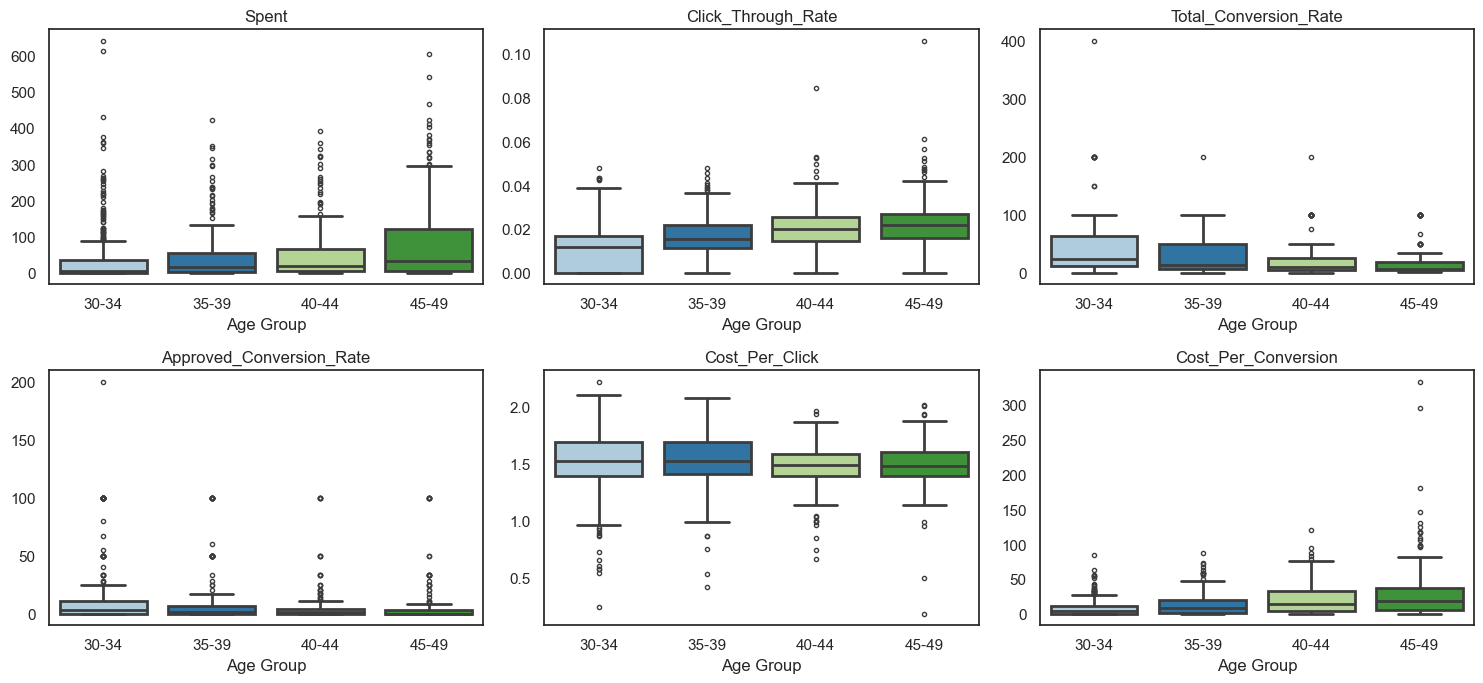

In [282]:
fig, axes = plt.subplots(2, 3, figsize=(15, 7))
axes = axes.flatten()

for i, col in enumerate(segement_cols_to_analyse):
    
    sns.boxplot(x='age', y=col, data=sales, ax=axes[i], 
                linewidth=2.0, fliersize=3.0, palette="Paired")
    
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel('Age Group')
    axes[i].set_ylabel(None)
    
plt.tight_layout()
plt.show()

<h3 style="font-family: 'Palatino Linotype', 'Book Antiqua', Palatino, serif; font-size: 28px; color: #2C3E50; font-weight: normal; text-align: left; margin-top: 15px; background: linear-gradient(to right, rgba(240, 240, 240, 0.8), rgba(220, 220, 220, 0.8)); padding: 15px; border-left: 5px solid #CB99C9; border-radius: 5px;">
    By Gender
</h3>

In [283]:
gender_analysis = sales.groupby('gender').agg({
    'Impressions': 'sum',
    'Clicks': 'sum',
    'Total_Conversion': 'sum',
    'Approved_Conversion': 'sum',
    'Spent': 'sum'
}).reset_index()

gender_analysis['Click_Through_Rate']       = (gender_analysis['Clicks']              / gender_analysis['Impressions']) * 100
gender_analysis['Total_Conversion_Rate']    = (gender_analysis['Total_Conversion']    / gender_analysis['Clicks'])      * 100
gender_analysis['Approved_Conversion_Rate'] = (gender_analysis['Approved_Conversion'] / gender_analysis['Clicks'])      * 100
gender_analysis['Cost_Per_Click']           = gender_analysis['Spent']                / gender_analysis['Clicks']
gender_analysis['Cost_Per_Conversion']      = gender_analysis['Spent']                / gender_analysis['Total_Conversion']

print("Analysis by Gender:")
gender_analysis

Analysis by Gender:


,gender,Impressions,Clicks,Total_Conversion,Approved_Conversion,Spent,Click_Through_Rate,Total_Conversion_Rate,Approved_Conversion_Rate,Cost_Per_Click,Cost_Per_Conversion
0,F,114862847,23878,1644,495,34502.619963,0.020788,6.884999,2.073038,1.444954,20.986995
1,M,98571981,14287,1620,584,24202.609995,0.014494,11.338979,4.087632,1.694030,14.939883


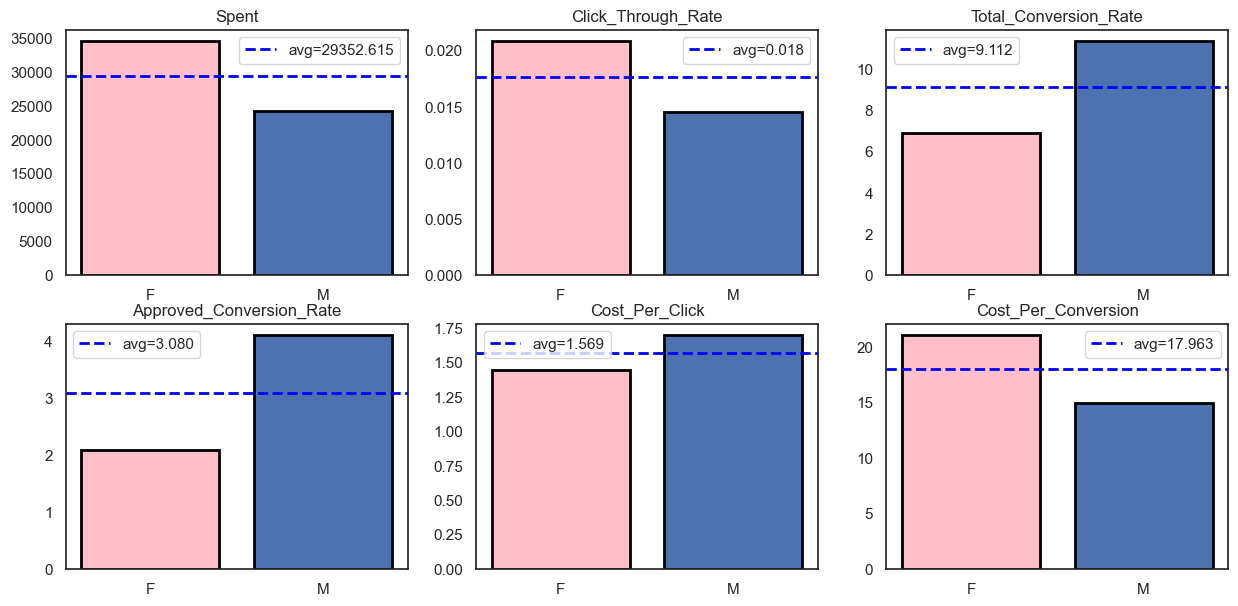

In [284]:
fig, axes = plt.subplots(2, 3, figsize=(15, 7))
axes = axes.flatten()
colors = ['pink', 'C0']

for i, col in enumerate(segement_cols_to_analyse):
    
    axes[i].bar(gender_analysis['gender'], gender_analysis[col], 
                color=colors, edgecolor='black', linewidth=2.0)
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel(None)
    
    mu = gender_analysis[col].mean()
    axes[i].axhline(mu, color='blue', linestyle='dashed', 
                    linewidth=2, label=f'avg={mu:0.3f}')
    axes[i].legend()
    
plt.show()

======== Statistics per gender =========


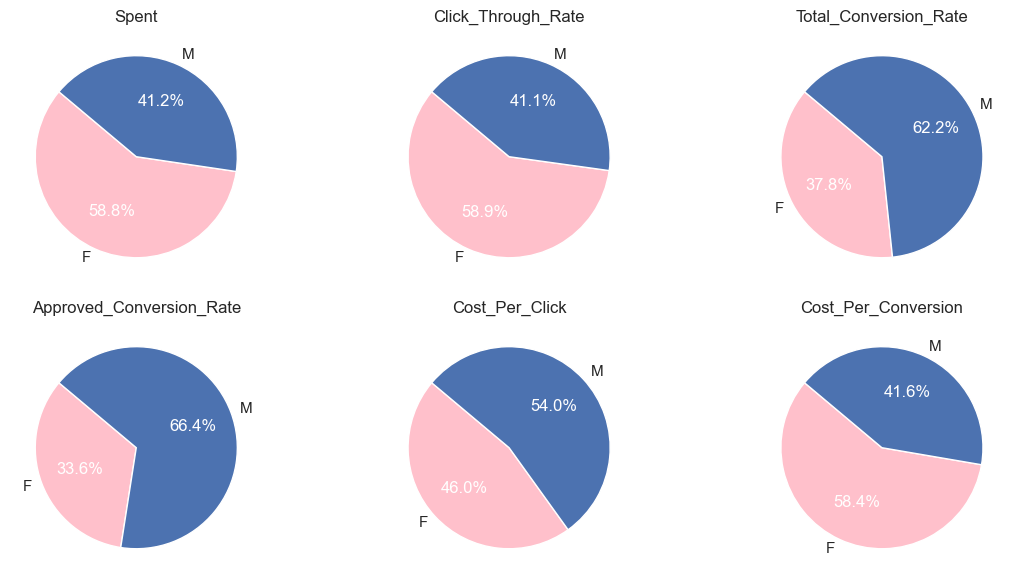

In [285]:
col_to_analyse = 'gender'

print(f"{40*'='}")
print(f"{' Statistics per ' + col_to_analyse + ' ':=^40}")
print(f"{40*'='}")

fig, axes = plt.subplots(2, 3, figsize=(12, 6))
axes = axes.flatten()

for i, col in enumerate(segement_cols_to_analyse):
    wedges, texts, autotexts = axes[i].pie(gender_analysis[col], 
                                           labels=gender_analysis['gender'], 
                                           colors=colors, 
                                           autopct='%1.1f%%', 
                                           startangle=140)
    axes[i].set_title(f'{col}')
    
    for text in autotexts:
        text.set_color('white')
    
plt.tight_layout()
plt.show()

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_23628\3363080756.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='gender', y=col, data=sales, ax=axes[i],
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_23628\3363080756.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='gender', y=col, data=sales, ax=axes[i],
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_23628\3363080756.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='gender', y=col, data=sales, ax=axes[i],
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_23628\3363080756.py:6: FutureWarnin

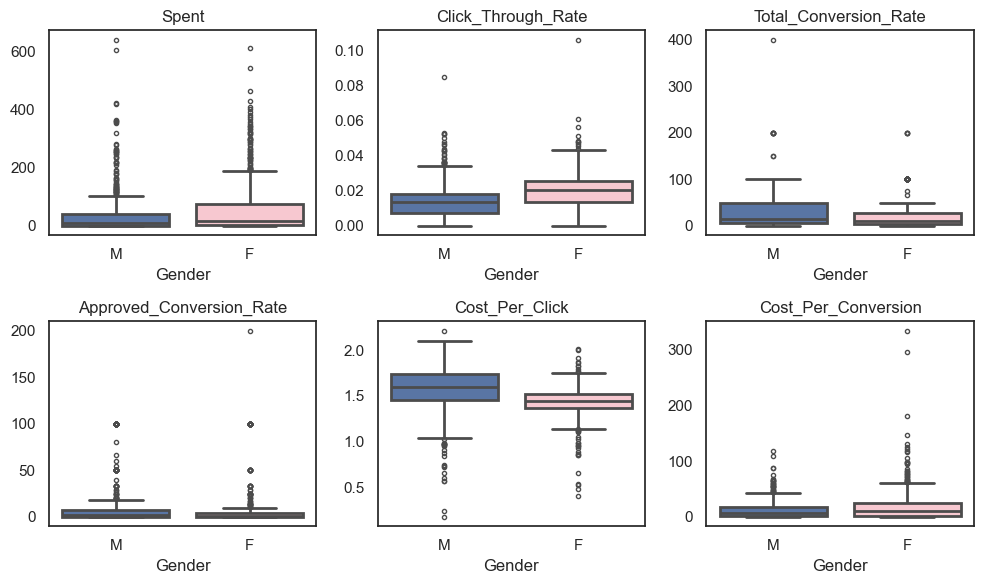

In [286]:
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
axes = axes.flatten()

for i, col in enumerate(segement_cols_to_analyse):
    
    sns.boxplot(x='gender', y=col, data=sales, ax=axes[i], 
                linewidth=2.0, fliersize=3.0, palette=['C0', 'pink'])
    
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel('Gender')
    axes[i].set_ylabel(None)
    
plt.tight_layout()
plt.show()

<h3 style="font-family: 'Palatino Linotype', 'Book Antiqua', Palatino, serif; font-size: 28px; color: #2C3E50; font-weight: normal; text-align: left; margin-top: 15px; background: linear-gradient(to right, rgba(240, 240, 240, 0.8), rgba(220, 220, 220, 0.8)); padding: 15px; border-left: 5px solid #CB99C9; border-radius: 5px;">
    By Interest
</h3>

In [287]:
interest_analysis = sales.groupby('interest').agg({
    'Impressions': 'sum',
    'Clicks': 'sum',
    'Total_Conversion': 'sum',
    'Approved_Conversion': 'sum',
    'Spent': 'sum'
}).reset_index()

interest_analysis['Click_Through_Rate']       = (interest_analysis['Clicks']              / interest_analysis['Impressions']) * 100
interest_analysis['Total_Conversion_Rate']    = (interest_analysis['Total_Conversion']    / interest_analysis['Clicks'])      * 100
interest_analysis['Approved_Conversion_Rate'] = (interest_analysis['Approved_Conversion'] / interest_analysis['Clicks'])      * 100
interest_analysis['Cost_Per_Click']           = interest_analysis['Spent']                / interest_analysis['Clicks']
interest_analysis['Cost_Per_Conversion']      = interest_analysis['Spent']                / interest_analysis['Total_Conversion']

print("Analysis by Interest:")
interest_analysis.head(5)

Analysis by Interest:


,interest,Impressions,Clicks,Total_Conversion,Approved_Conversion,Spent,Click_Through_Rate,Total_Conversion_Rate,Approved_Conversion_Rate,Cost_Per_Click,Cost_Per_Conversion
0,2,1727646,311,40,19,503.450005,0.018001,12.861736,6.109325,1.618810,12.586250
1,7,2612839,410,59,19,648.929999,0.015692,14.390244,4.634146,1.582756,10.998814
2,10,17989844,3317,269,91,5086.379995,0.018438,8.109738,2.743443,1.533428,18.908476
3,15,10745856,1609,195,63,2597.259995,0.014973,12.119329,3.915475,1.614208,13.319282
4,16,31809524,5144,411,141,8084.909990,0.016171,7.989891,2.741058,1.571717,19.671314


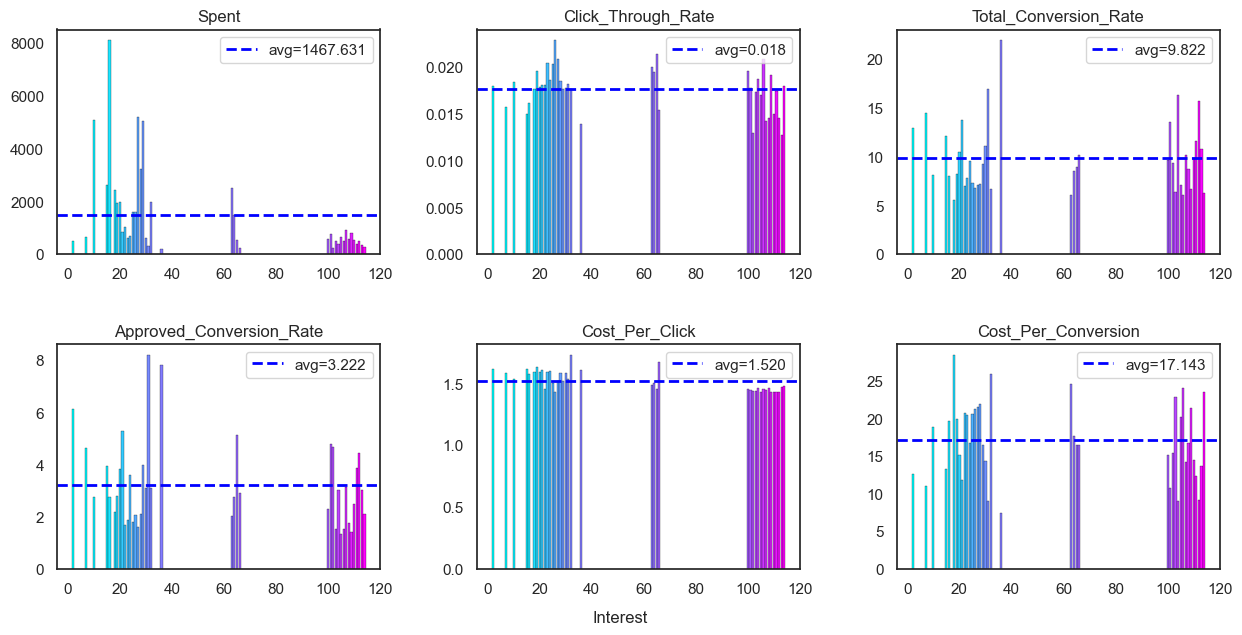

In [288]:
fig, axes = plt.subplots(2, 3, figsize=(15, 7))
axes = axes.flatten()
colors = plt.cm.cool(np.linspace(0, 1, len(interest_analysis['interest'])))

for i, col in enumerate(segement_cols_to_analyse):
    
    axes[i].bar(interest_analysis['interest'], interest_analysis[col], 
                color=colors, edgecolor='black', linewidth=0.2)
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel(None)
    
    mu = interest_analysis[col].mean()
    axes[i].axhline(mu, color='blue', linestyle='dashed', 
                    linewidth=2, label=f'avg={mu:0.3f}')
    axes[i].legend()
    
fig.text(0.5, 0.04, 'Interest', ha='center', va='center', fontsize=12)
fig.subplots_adjust(hspace=0.4, wspace=0.3)    
    
plt.show()

<h2 style="font-family: 'Palatino Linotype', 'Book Antiqua', Palatino, serif; font-size: 36px; color: #2C3E50; font-weight: bold; text-align: left; margin-top: 20px; background-color: rgba(225, 190, 231, 0.6); padding: 20px; border-radius: 10px;">
    Campaign Performance Analysis
</h2>

In this section we are going to investigate the 
- _Ad Campaign Effectiveness_ for which we need to evaluate the effectiveness of different ad campaigns (`xyz_campaign_id`, `fb_campaign_id`) by analyzing their conversion rates and cost efficiency. 
- _Top-Performing Ads_ for which we need to idenitfy ads (based on `ad_id`) that have the highest conversion rates or lowest costs.

In [289]:
sales_subset = sales[sales['Clicks'] > 0]

<h3 style="font-family: 'Palatino Linotype', 'Book Antiqua', Palatino, serif; font-size: 28px; color: #2C3E50; font-weight: normal; text-align: left; margin-top: 15px; background: linear-gradient(to right, rgba(240, 240, 240, 0.8), rgba(220, 220, 220, 0.8)); padding: 15px; border-left: 5px solid #CB99C9; border-radius: 5px;">
    Add Campaign Effectiveness
</h3>

In [290]:
# --------------------------------------------- #
# Investigate the effectivenss of XYZ campaigns #
# --------------------------------------------- #

xyz_campaign_effectiveness = sales_subset.groupby('xyz_campaign_id').agg({
    'Impressions': 'sum',
    'Clicks': 'sum',
    'Spent': 'sum',
    'Total_Conversion': 'sum',
    'Approved_Conversion': 'sum'
}).reset_index()

# Calculate Conversion Rates and Cost Efficiency.
xyz_campaign_effectiveness['Click_Through_Rate (%)'] = (xyz_campaign_effectiveness['Clicks'] / xyz_campaign_effectiveness['Impressions']) * 100
xyz_campaign_effectiveness['Total_Conversion_Rate (%)'] = (xyz_campaign_effectiveness['Total_Conversion'] / xyz_campaign_effectiveness['Clicks']) * 100
xyz_campaign_effectiveness['Approved_Conversion_Rate (%)'] = (xyz_campaign_effectiveness['Approved_Conversion'] / xyz_campaign_effectiveness['Clicks']) * 100
xyz_campaign_effectiveness['Cost_Per_Click'] = xyz_campaign_effectiveness['Spent'] / xyz_campaign_effectiveness['Clicks']
xyz_campaign_effectiveness['Cost_Per_Conversion'] = xyz_campaign_effectiveness['Spent'] / xyz_campaign_effectiveness['Total_Conversion']

# Sort by effectiveness (e.g., highest Total Conversion Rate).
xyz_campaign_effectiveness = xyz_campaign_effectiveness.sort_values(by='Total_Conversion_Rate (%)', ascending=False)

# Display the results
print("XYZ Campaign Effectiveness")
print("==========================")
print(f"Number of XYZ campaigns: {xyz_campaign_effectiveness.shape[0]:,}")
xyz_campaign_effectiveness.head()

XYZ Campaign Effectiveness
Number of XYZ campaigns: 3


,xyz_campaign_id,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion,Click_Through_Rate (%),Total_Conversion_Rate (%),Approved_Conversion_Rate (%),Cost_Per_Click,Cost_Per_Conversion
0,916,448046,113,149.710001,39,16,0.025221,34.513274,14.159292,1.324867,3.838718
1,936,7797942,1984,2893.369999,356,118,0.025443,17.943548,5.947581,1.458352,8.127444
2,1178,204699959,36068,55662.149959,2657,869,0.017620,7.366641,2.409338,1.543256,20.949247


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_23628\3021149710.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=xyz_campaign_effectiveness,


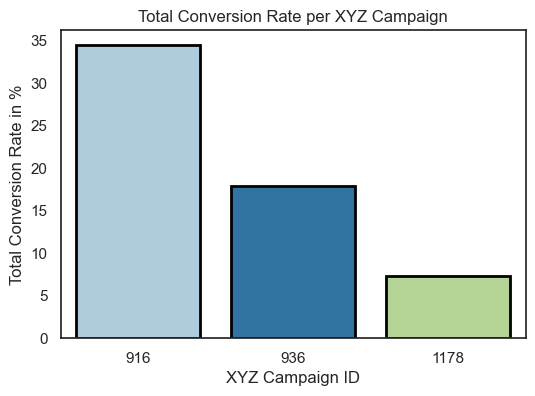

In [291]:
plt.figure(figsize=(6, 4))

sns.barplot(data=xyz_campaign_effectiveness, 
            x='xyz_campaign_id', y='Total_Conversion_Rate (%)', 
            edgecolor='black', linewidth=2.0,
            palette='Paired')
plt.title('Total Conversion Rate per XYZ Campaign')
plt.xlabel('XYZ Campaign ID')
plt.ylabel('Total Conversion Rate in %')

plt.show()

In [292]:
# -------------------------------------------------- #
# Investigate the effectivenss of Facebook campaigns #
# -------------------------------------------------- #

fb_campaign_effectiveness = sales_subset.groupby('fb_campaign_id').agg({
    'Impressions': 'sum',
    'Clicks': 'sum',
    'Spent': 'sum',
    'Total_Conversion': 'sum',
    'Approved_Conversion': 'sum'
}).reset_index()

# Calculate Conversion Rates and Cost Efficiency.
fb_campaign_effectiveness['Click_Through_Rate (%)'] = (fb_campaign_effectiveness['Clicks'] / fb_campaign_effectiveness['Impressions']) * 100
fb_campaign_effectiveness['Total_Conversion_Rate (%)'] = (fb_campaign_effectiveness['Total_Conversion'] / fb_campaign_effectiveness['Clicks']) * 100
fb_campaign_effectiveness['Approved_Conversion_Rate (%)'] = (fb_campaign_effectiveness['Approved_Conversion'] / fb_campaign_effectiveness['Clicks']) * 100
fb_campaign_effectiveness['Cost_Per_Click'] = fb_campaign_effectiveness['Spent'] / fb_campaign_effectiveness['Clicks']
fb_campaign_effectiveness['Cost_Per_Conversion'] = fb_campaign_effectiveness['Spent'] / fb_campaign_effectiveness['Total_Conversion']

# Sort by effectiveness (e.g., highest Total Conversion Rate).
fb_campaign_effectiveness = fb_campaign_effectiveness.sort_values(by='Total_Conversion_Rate (%)', ascending=False)

print("Facebook Campaign Effectiveness")
print("===============================")
print(f"Number of Facebook campaigns: {fb_campaign_effectiveness.shape[0]:,}")
fb_campaign_effectiveness.head()

Facebook Campaign Effectiveness
Number of Facebook campaigns: 543


,fb_campaign_id,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion,Click_Through_Rate (%),Total_Conversion_Rate (%),Approved_Conversion_Rate (%),Cost_Per_Click,Cost_Per_Conversion
35,108668,5374,1,1.04,4,0,0.018608,400.0,0.0,1.04,0.260
30,104396,3812,1,1.13,2,1,0.026233,200.0,100.0,1.13,0.565
157,115737,5209,1,0.96,2,0,0.019198,200.0,0.0,0.96,0.480
196,116220,6175,1,1.37,2,1,0.016194,200.0,100.0,1.37,0.685
183,116061,8613,1,0.89,2,0,0.011610,200.0,0.0,0.89,0.445


<h3 style="font-family: 'Palatino Linotype', 'Book Antiqua', Palatino, serif; font-size: 28px; color: #2C3E50; font-weight: normal; text-align: left; margin-top: 15px; background: linear-gradient(to right, rgba(240, 240, 240, 0.8), rgba(220, 220, 220, 0.8)); padding: 15px; border-left: 5px solid #CB99C9; border-radius: 5px;">
    Top-Performing Ads
</h3>

In [293]:
ad_effectiveness = sales_subset.groupby('ad_id').agg({
    'Impressions': 'sum',
    'Clicks': 'sum',
    'Spent': 'sum',
    'Total_Conversion': 'sum',
    'Approved_Conversion': 'sum'
}).reset_index()

# Calculate Conversion Rates and Cost Efficiency.
ad_effectiveness['Click_Through_Rate (%)'] = (ad_effectiveness['Clicks'] / ad_effectiveness['Impressions']) * 100
ad_effectiveness['Total_Conversion_Rate (%)'] = (ad_effectiveness['Total_Conversion'] / ad_effectiveness['Clicks']) * 100
ad_effectiveness['Approved_Conversion_Rate (%)'] = (ad_effectiveness['Approved_Conversion'] / ad_effectiveness['Clicks']) * 100
ad_effectiveness['Cost_Per_Click'] = ad_effectiveness['Spent'] / ad_effectiveness['Clicks']
ad_effectiveness['Cost_Per_Conversion'] = ad_effectiveness['Spent'] / ad_effectiveness['Total_Conversion']

# Top-performing ads by conversion rate.
top_conversion_ads = ad_effectiveness.sort_values(by='Total_Conversion_Rate (%)', ascending=False).head(10)

# Top-performing ads by lowest cost per conversion.
lowest_cost_ads = ad_effectiveness.sort_values(by='Cost_Per_Conversion', ascending=True).head(10)

In [294]:
print("Top-Performing Ads by Conversion Rate")
print(f"Number of ads: {top_conversion_ads.shape[0]}")

avg_total_cr = sales_subset['Total_Conversion_Rate'].mean()
print(f"Note that the average Total Conversion Rate is {avg_total_cr:0.2f} %")

top_conversion_ads['% Higher Than Average'] = round(100 * (top_conversion_ads['Total_Conversion_Rate (%)'] / avg_total_cr), 2)

top_conversion_ads[['ad_id', 'Total_Conversion_Rate (%)', '% Higher Than Average']]

Top-Performing Ads by Conversion Rate
Number of ads: 10
Note that the average Total Conversion Rate is 29.52 %


,ad_id,Total_Conversion_Rate (%),% Higher Than Average
37,734290,400.0,1355.23
352,1121129,200.0,677.62
334,1121107,200.0,677.62
32,711623,200.0,677.62
189,777758,200.0,677.62
219,779622,200.0,677.62
236,780511,200.0,677.62
0,708746,200.0,677.62
330,1121101,200.0,677.62
305,951391,200.0,677.62


- The Ad with the highest total CR has a total CR which is __more then 13 times higher than the average CR__.
- All the other top 10 Ads have a more than 6 times higher CR than the average CR.

In [295]:
print("Top-Performing Ads by Lowest Cost Per Conversion")
print(f"Number of ads: {lowest_cost_ads.shape[0]}")

average_cost_per_conversion = sales_subset[sales_subset['Cost_Per_Conversion'] != np.inf]['Cost_Per_Conversion'].mean()
print(f"Note that the average Cost Per Conversion is {average_cost_per_conversion:0.2f}")

# How much percent lower are the top lowest cost ads compared to the avergae cost of ads?
lowest_cost_ads['% Lower Than Average'] = 100 * (average_cost_per_conversion - lowest_cost_ads['Cost_Per_Conversion']) / average_cost_per_conversion

lowest_cost_ads[['ad_id', 'Cost_Per_Conversion', '% Lower Than Average']]

Top-Performing Ads by Lowest Cost Per Conversion
Number of ads: 10
Note that the average Cost Per Conversion is 19.66


,ad_id,Cost_Per_Conversion,% Lower Than Average
174,777105,0.180,99.084618
69,736869,0.240,98.779491
37,734290,0.260,98.677782
94,747223,0.300,98.474363
315,951756,0.410,97.914963
219,779622,0.445,97.736972
189,777758,0.480,97.558981
134,776416,0.490,97.508127
258,781354,0.530,97.304709
78,737931,0.540,97.253854


<h2 style="font-family: 'Palatino Linotype', 'Book Antiqua', Palatino, serif; font-size: 36px; color: #2C3E50; font-weight: bold; text-align: left; margin-top: 20px; background-color: rgba(225, 190, 231, 0.6); padding: 20px; border-radius: 10px;">
    A/B Testing Analysis
</h2>

We can only "simulate" A/B testing for the given dataset. This is because A/B testing usually involves comparing two or more versions of the same element (e.g., different ad creatives or messages) shown to similar audience segments. Our dataset doesn't explicitly show different variants of a single campaign, but rather different ads and campaigns.

Also, since the dataset involves multiple campaigns with potentially different audience segments (e.g., `age`, `gender`, `interest`), impressions, and other variables, it's hard to isolate the effect of a single variable (like a campaign variation) without considering the impact of other factors.

So, true A/B testing would involve:
- Same Audience: Splitting the same audience randomly into two or more groups.
- Controlled Variations: Showing each group a different version of the ad (e.g., different creative, messaging) while keeping all other variables constant.
- Direct Comparison: Measuring which version performs better in terms of conversions, clicks, or another specific metric.

Also, normally we would perform the following steps: 

1. Define Hypotheses: What are you testing for?
2. Randomization: Ensure users are randomly assigned to groups.
3. Run Experiment: Gather data.
4. Calculate Metrics: Such as conversion rates.
5. Statistical Testing: Use a suitable test (e.g., z-test) to determine significance.
6. Conclusions: Make a decision based on the statistical test results.

What we can do though is to group ads by similar characteristics (same `age` range, `gender`, and `interest`) and then compare how different campaigns (`xyz_campaign_id` or `fb_campaign_id`) perform within these groups.

In [296]:
# ---------------- #
# Prepare the data #
# ---------------- #

campaign_ids = [916, 936, 1178]

# Filter the campaigns.
df_campaigns = sales[sales['xyz_campaign_id'].isin(campaign_ids)]

# Aggregate per campaign.
summary_campaigns = df_campaigns.groupby('xyz_campaign_id').agg({
    'Clicks': 'sum',
    'Impressions': 'sum',
    'Total_Conversion': 'sum'
}).reset_index()


summary_campaigns['Conversion Rate'] = summary_campaigns['Total_Conversion'] / summary_campaigns['Clicks']

print("Summary of Campaigns:")
summary_campaigns

Summary of Campaigns:


,xyz_campaign_id,Clicks,Impressions,Total_Conversion,Conversion Rate
0,916,113,482925,58,0.513274
1,936,1984,8128187,537,0.270665
2,1178,36068,204823716,2669,0.073999


In [297]:
# ----------------------- #
# Conduct Chi-Square Test #
# ----------------------- #

from scipy.stats import chi2_contingency

# Create contingency table.
contingency_table = pd.crosstab(df_campaigns['xyz_campaign_id'], df_campaigns['Total_Conversion'])

# Perform Chi-Square test.
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-Square Statistic: {chi2_stat:.4f}")
print(f"P-Value: {p_value:.4f}")

Chi-Square Statistic: 368.5843
P-Value: 0.0000


In [298]:
# ----------------- #
# Interpret p-value #
# ----------------- #

ALPHA = 0.05

if p_value < ALPHA:
    print("Reject the null hypothesis. There is a significant difference in conversion rates among the campaigns.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference in conversion rates among the campaigns.")

Reject the null hypothesis. There is a significant difference in conversion rates among the campaigns.


In [299]:
# ----------------------- #
# Conduct Chi-Square Test #
# ----------------------- #

from scipy.stats import chi2_contingency

# Create contingency table.
contingency_table = pd.crosstab(df_campaigns['Spent'], df_campaigns['Total_Conversion'])

# Perform Chi-Square test.
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-Square Statistic: {chi2_stat:.4f}")
print(f"P-Value: {p_value:.4f}")

# ----------------- #
# Interpret p-value #
# ----------------- #

ALPHA = 0.05

if p_value < ALPHA:
    print("Reject the null hypothesis. There is a significant difference in conversion rates among the campaigns.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference in conversion rates among the campaigns.")

Chi-Square Statistic: 34797.1763
P-Value: 0.0000
Reject the null hypothesis. There is a significant difference in conversion rates among the campaigns.


<h2 style="font-family: 'Palatino Linotype', 'Book Antiqua', Palatino, serif; font-size: 36px; color: #2C3E50; font-weight: bold; text-align: left; margin-top: 20px; background-color: rgba(225, 190, 231, 0.6); padding: 20px; border-radius: 10px;">
    Predictive Modeling
</h2>

In [300]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import OneHotEncoder

In [301]:
features = ['age', 'gender', 'interest', 'Impressions', 'Clicks', 'Spent']
target = 'Total_Conversion_Group'

sales_encoded = pd.get_dummies(sales[features])  # One-hot encode categorical features.
sales[target] = pd.qcut(sales['Total_Conversion'], q=3, labels=False)

X_train, X_test, y_train, y_test = train_test_split(sales_encoded, sales[target], 
                                                    test_size=0.3, random_state=RANDOM_STATE)
print(f"X_train: {X_train.shape[0]:,} (rows)")
print(f"X_test : {X_test.shape[0]:,} (rows)")

X_train: 800 (rows)
X_test : 343 (rows)


In [302]:
sales[target].value_counts()

Total_Conversion_Group
0    674
2    307
1    162
Name: count, dtype: int64

In [303]:
quantiles = pd.qcut(sales['Total_Conversion'], q=3, retbins=True, labels=False)
bucket_ranges = quantiles[1]

bucket_labels = [
    f'Low Conversion\n[{bucket_ranges[0]:.0f} - {bucket_ranges[1]:.0f}]',
    f'Medium Conversion\n[{bucket_ranges[1]:.0f} - {bucket_ranges[2]:.0f}]',
    f'High Conversion\n[{bucket_ranges[2]:.0f} - {bucket_ranges[3]:.0f}]'
]
bucket_labels

['Low Conversion\n[0 - 1]',
 'Medium Conversion\n[1 - 2]',
 'High Conversion\n[2 - 60]']

In [304]:
model = RandomForestClassifier(random_state=RANDOM_STATE)

model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [305]:
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7288629737609329
              precision    recall  f1-score   support

           0       0.78      0.88      0.83       207
           1       0.15      0.07      0.10        43
           2       0.71      0.70      0.71        93

    accuracy                           0.73       343
   macro avg       0.55      0.55      0.54       343
weighted avg       0.69      0.73      0.70       343



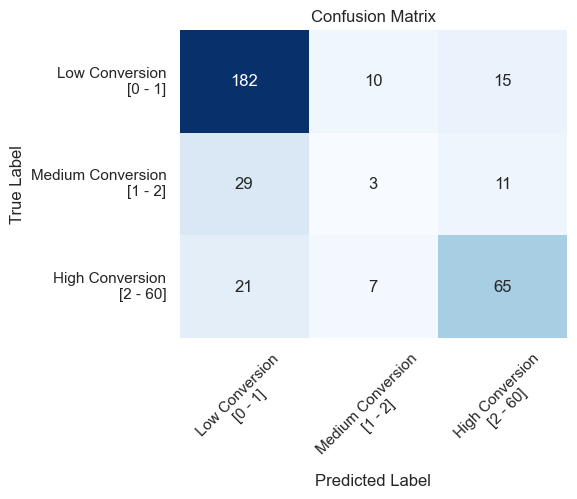

In [306]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=bucket_labels, 
            yticklabels=bucket_labels)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.xticks(rotation=45)
plt.show()

In [307]:
y_probas = model.predict_proba(X_test)
y_probas

array([[1.  , 0.  , 0.  ],
       [0.3 , 0.26, 0.44],
       [0.66, 0.34, 0.  ],
       ...,
       [0.94, 0.06, 0.  ],
       [0.9 , 0.1 , 0.  ],
       [0.07, 0.09, 0.84]])

In [308]:
class_0_probs = y_probas[:, 0]
class_1_probs = y_probas[:, 1]
class_2_probs = y_probas[:, 2]

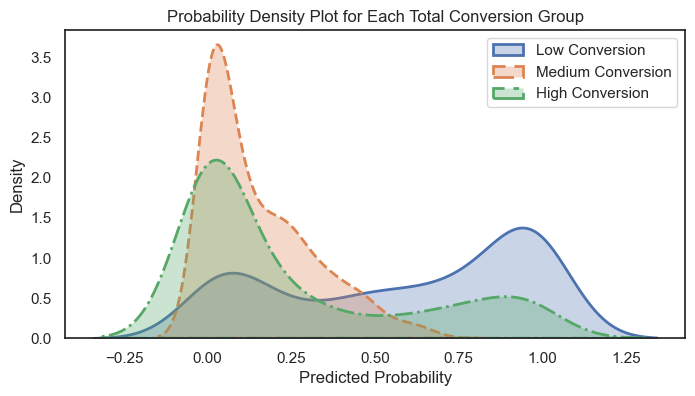

In [309]:
plt.figure(figsize=(8, 4))

sns.kdeplot(class_0_probs, fill=True, alpha=0.3, lw=2, linestyle='-', label='Low Conversion')
sns.kdeplot(class_1_probs, fill=True, alpha=0.3, lw=2, linestyle='--', label='Medium Conversion')
sns.kdeplot(class_2_probs, fill=True, alpha=0.3, lw=2, linestyle='-.', label='High Conversion')

plt.title('Probability Density Plot for Each Total Conversion Group')
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.legend()
plt.show()

In [425]:
# sales1 = sales
sales = sales1

In [426]:
def filter_interest(df, column_name, threshold=0.74, new_column_name='filtered_interest'):
    value_counts = df[column_name].value_counts()
    total_count = value_counts.sum()
    cum_count = 0
    keep_values = []

    for value, count in value_counts.items():
        cum_count += count
        if cum_count / total_count <= threshold:
            keep_values.append(value)
        else:
            break

    filtered_df = df.copy()
    filtered_df[new_column_name] = filtered_df[column_name].apply(lambda x: x if x in keep_values else 'other')
    return filtered_df


sales = filter_interest(sales, 'interest', threshold=0.72, new_column_name='pareto_interest')

In [427]:
columns_to_one_hot_encode = ['gender','age', 'pareto_interest']

dis_interest = sales['pareto_interest'].unique()
dis_gender = sales['gender'].unique()
dis_age = sales['age'].unique()

df_dummies = pd.get_dummies(sales[columns_to_one_hot_encode], prefix='', prefix_sep='')

# Convert boolean columns to integers
boolean_columns = df_dummies.select_dtypes(include='bool').columns
df_dummies[boolean_columns] = df_dummies[boolean_columns].astype(int)
sales = pd.concat([sales, df_dummies], axis=1)

df2 = sales.drop(['xyz_campaign_id', 'fb_campaign_id', 'Click_Through_Rate', 'Total_Conversion_Rate', 'Approved_Conversion_Rate', 'Cost_Per_Click', 'Cost_Per_Conversion', 'Total_Conversion_Group'], axis=1).set_index('ad_id')

R2 Score for Test Set: 0.7818
MAPE for Test Set: 0.4019


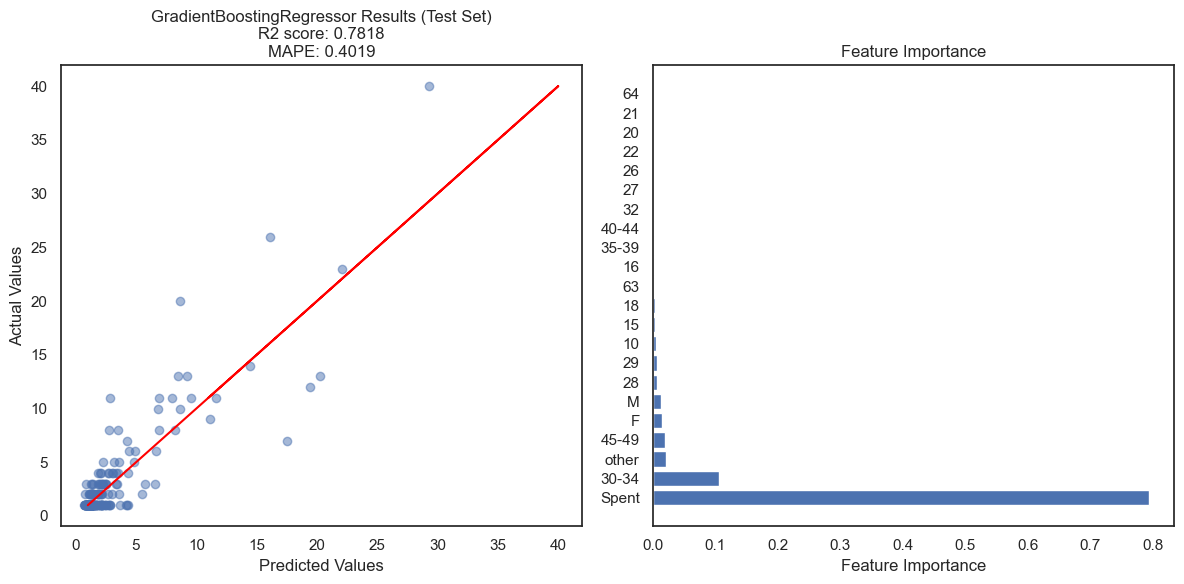

In [428]:

# Chuẩn bị dữ liệu
X = df2.drop(['pareto_interest', 'interest', 'age', 'gender', 'Total_Conversion', 'Approved_Conversion', 'Impressions', 'Clicks'], axis=1)
Y = df2[['Total_Conversion']]

# Chia dữ liệu thành train-test
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Huấn luyện mô hình Gradient Boosting Regressor
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor()
model.fit(X_train, Y_train.values.ravel())  # .ravel() để chuyển Y từ 2D thành 1D

# Tính toán R2 score và MAPE cho tập huấn luyện
Y_train_pred = model.predict(X_train)

# Tính toán R2 score và MAPE cho tập kiểm tra
Y_test_pred = model.predict(X_test)
r2_test = r2_score(Y_test, Y_test_pred)
mape_test = mean_absolute_percentage_error(Y_test, Y_test_pred)

print(f"R2 Score for Test Set: {r2_test:.4f}")
print(f"MAPE for Test Set: {mape_test:.4f}")

# Vẽ đồ thị kết quả và tầm quan trọng của đặc trưng
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Đồ thị giá trị dự đoán vs giá trị thực tế cho tập kiểm tra
ax[0].scatter(Y_test_pred, Y_test, alpha=0.5)
ax[0].plot(Y_test, Y_test, color='red')
ax[0].set_xlabel('Predicted Values')
ax[0].set_ylabel('Actual Values')
ax[0].set_title(f'GradientBoostingRegressor Results (Test Set)\nR2 score: {r2_test:.4f}\nMAPE: {mape_test:.4f}')

# Vẽ biểu đồ tầm quan trọng của đặc trưng
feature_importance = model.feature_importances_
sorted_indices = feature_importance.argsort()[::-1]  # Sắp xếp giảm dần theo độ quan trọng
sorted_features = X.columns[sorted_indices]          # Lấy tên đặc trưng dựa trên chỉ số

ax[1].barh(range(len(feature_importance)), feature_importance[sorted_indices])
ax[1].set_yticks(range(len(feature_importance)))
ax[1].set_yticklabels(sorted_features)
ax[1].set_xlabel('Feature Importance')
ax[1].set_title('Feature Importance')

plt.tight_layout()
plt.show()


In [437]:
combinations = []

# Lặp qua từng giá trị và tạo tổ hợp
for age in dis_age:
    for gender in dis_gender:
        for interest in dis_interest:
            combinations.append({'age': age, 'gender': gender, 'interest': interest})

# Chuyển đổi danh sách thành DataFrame
df_combinations = pd.DataFrame(combinations)



In [438]:
columns_to_one_hot_encode = ['gender','age', 'interest']

# Use get_dummies to create dummy variables for specified columns
df_combinations = pd.get_dummies(df_combinations[columns_to_one_hot_encode], prefix='', prefix_sep='')

# Convert boolean columns to integers
boolean_columns = df_combinations.select_dtypes(include='bool').columns
df_combinations[boolean_columns] = df_combinations[boolean_columns].astype(int)
df_combinations.insert(0, 'Spent', 0)

In [439]:
df_combinations['Spent'] = 1000

pred = model.predict(df_combinations)

max_index = np.argmax(pred)
max_value = pred[max_index]

best_config = df_combinations.iloc[max_index]

print(f"Cấu hình đầu vào tối ưu: {best_config}")
print(f"Giá trị Total_Conversion dự đoán tối đa: {max_value:.4f}")

Cấu hình đầu vào tối ưu: Spent    1000
F           0
M           1
30-34       1
35-39       0
40-44       0
45-49       0
10          0
15          1
16          0
18          0
20          0
21          0
22          0
26          0
27          0
28          0
29          0
32          0
63          0
64          0
other       0
Name: 0, dtype: int64
Giá trị Total_Conversion dự đoán tối đa: 59.9371


In [500]:
# Định nghĩa các khoảng giá trị Spent
spent_ranges = {
    '1 => 39': (1, 39),
    '40 => 79': (40, 79),
    '80 => 119': (80, 119),
    '120 => 159': (120, 159),
    '160 => 169': (160, 169),
    '170 => 179': (170, 179),
    '180 => 189': (180, 189),
    '190 => 199': (190, 199),
    '200 => 399': (200, 399),
    '400 => 600': (400, 600),
}

# Tạo danh sách để lưu kết quả
results = []

# Lặp qua từng khoảng Spent
for range_name, (min_spent, max_spent) in spent_ranges.items():
    for spent in range(min_spent, max_spent):
        # Tạo bản sao của df_combinations để thay đổi giá trị Spent
        df_test = df_combinations.copy()
        
        # Gán giá trị Spent trong khoảng tương ứng
        df_test['Spent'] = spent

        # Dự đoán với mô hình
        pred = model.predict(df_test)
        
        # Tìm giá trị Prediction lớn nhất
        max_idx = np.argmax(pred)
        max_row = df_test.iloc[max_idx].to_dict()
        
        # Thêm thông tin vào hàng tối ưu
        max_row['Spent'] = spent
        max_row['Total_Conversion_Pred'] = pred[max_idx]
        max_row['Spent_Range'] = range_name

        # Lưu kết quả hàng tốt nhất
        results.append(max_row)

# Chuyển danh sách kết quả thành DataFrame
results_df = pd.DataFrame(results)

# Hiển thị kết quả
print(results_df.head())


   Spent  F  M  30-34  35-39  40-44  45-49  10  15  16  ...  26  27  28  29  \
0      1  0  1      1      0      0      0   0   0   0  ...   0   0   0   1   
1      2  0  1      1      0      0      0   0   0   0  ...   0   0   0   1   
2      3  0  1      1      0      0      0   0   0   0  ...   0   0   0   1   
3      4  0  1      1      0      0      0   0   0   0  ...   0   0   0   1   
4      5  0  1      1      0      0      0   0   0   0  ...   0   0   0   1   

   32  63  64  other  Total_Conversion_Pred  Spent_Range  
0   0   0   0      0               1.750591      1 => 39  
1   0   0   0      0               1.819324      1 => 39  
2   0   0   0      0               1.819324      1 => 39  
3   0   0   0      0               1.837031      1 => 39  
4   0   0   0      0               2.018071      1 => 39  

[5 rows x 24 columns]


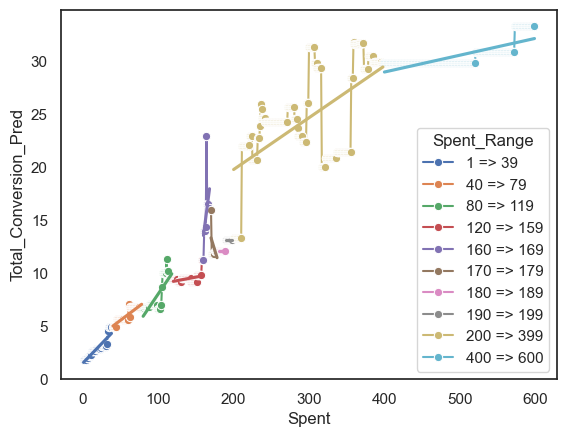

In [501]:
sns.lineplot(data=results_df, x='Spent', y='Total_Conversion_Pred', hue='Spent_Range', marker='o')
for range_name in results_df['Spent_Range'].unique():
    subset = results_df[results_df['Spent_Range'] == range_name]
    sns.regplot(
        data=subset, 
        x='Spent', 
        y='Total_Conversion_Pred', 
        scatter=False, 
        label=f'Xu hướng - {range_name}', 
        ci=None
    )

In [502]:
sum_results = []

for range_name in results_df['Spent_Range'].unique():
    spent_df = results_df[results_df['Spent_Range'] == range_name]
    
    sum_stats = spent_df.sum()

    sum_stats['Spent_Range'] = range_name  # Thêm cột 'Spent_Range' vào thông tin tổng
    sum_results.append(sum_stats)

sum_stats_df = pd.DataFrame(sum_results)
sum_stats_df = sum_stats_df.loc[:, sum_stats_df.sum() != 0]

# Hiển thị kết quả
print(sum_stats_df.drop(['Total_Conversion_Pred'], axis=1))

   Spent  F    M  30-34  40-44   10  27  29  other Spent_Range
0    741  0   38     38      0    0   0  38      0     1 => 39
1   2301  0   39     39      0    0   0  39      0    40 => 79
2   3861  0   39     39      0    0   0  39      0   80 => 119
3   5421  0   39     39      0    0   0  39      0  120 => 159
4   1476  0    9      9      0    0   4   5      0  160 => 169
5   1566  0    9      9      0    0   9   0      0  170 => 179
6   1656  0    9      9      0    0   9   0      0  180 => 189
7   1746  0    9      9      0    9   0   0      0  190 => 199
8  59501  4  195    196      3  181   0   0     18  200 => 399
9  99900  0  200    200      0  200   0   0      0  400 => 600
